In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pyod.models.dif import DIF
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

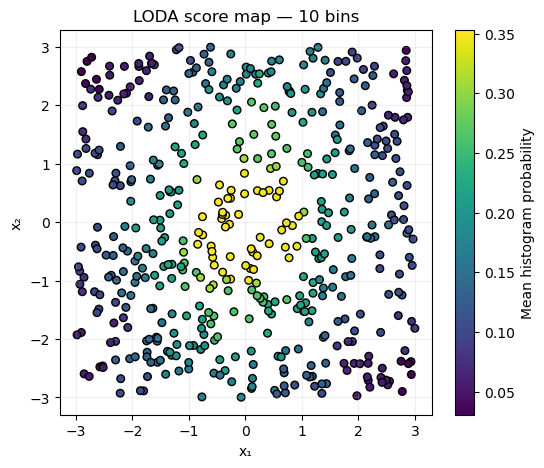

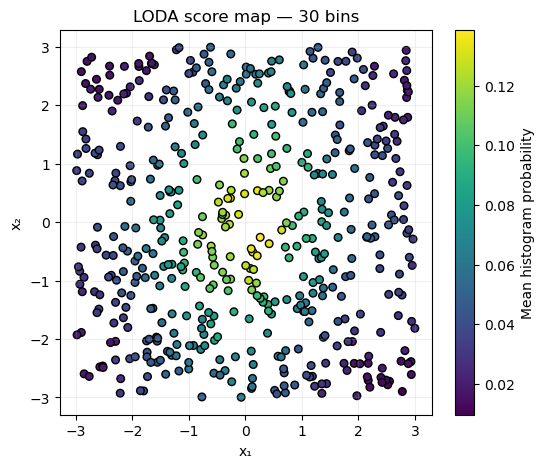

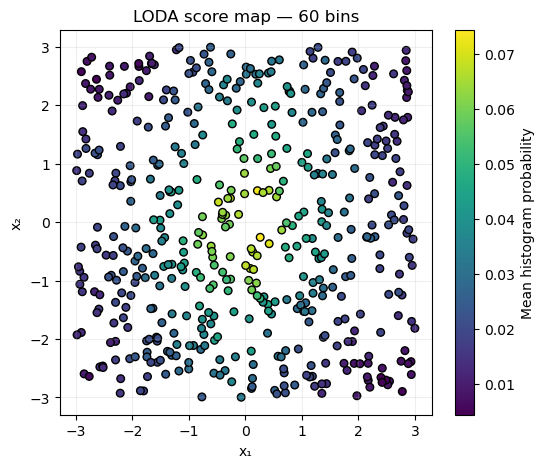

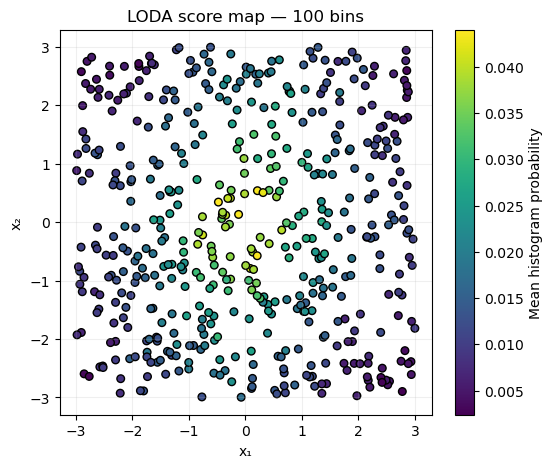

In [2]:
# Ex. 1
# 1. In the first exercise you will design a simpler variant of LODA. First you will generate a 2D dataset that follows
# a standard normal distribution (500 points) using sklearn.datasets.make blobs.
# 2. Then you will randomly generate 5 unit-length projection vectors (you can use numpy.random.multivariate normal with
# (0, 0) mean and identity matrix as covariance matrix) that will be used to generate 1D histograms (for the projected 
# values). You will compute the corresponding histograms with equal-width bins using numpy.histogram (for the range 
# parameter use a larger interval than the range of the projected values). For each histogram compute the probability
# corresponding to each bin and use them to compute the anomaly score of a sample as the mean of the probabilities
# (corresponding to each histogram).
# 3. For testing, generate a dataset with 500 points from a uniform distribution (between-3 and 3 using np.random.uniform).
# Plot the points in the test dataset using a colormap (related to the anomaly scores).
# 4. Use different number of bins and see how this affects the score map.

# 1. using sklearn.datasets.make blobs to generate a 2D dataset that follows a standard normal distribution (500 points)
train_data, _ = make_blobs(n_samples=500,n_features=2,centers=1,cluster_std=1.0,center_box=(0.0, 0.0),random_state=42)

# 2. generating 5 random unit-length projection vectors 
# using numpy.random.multivariate with (0, 0) mean and identity matrix as covariance matrix
rng = np.random.RandomState(0)
proj_vectors = rng.multivariate_normal(mean=[0,0], cov=np.eye(2), size=5)
proj_vectors = proj_vectors / np.linalg.norm(proj_vectors, axis=1, keepdims=True) # normalize to unit length

# precompute projections of training data
projected_vals = [train_data.dot(v) for v in proj_vectors]

# 3. generating a dataset with 500 points from a uniform distribution using np.random.uniform
test_data = rng.uniform(low=-3, high=3, size=(500, 2))

for num_bins in [10, 30, 60, 100]:
    histograms = []
    bin_edges_list = []

    for proj in projected_vals:
        # using numpy.histogram to compute the corresponding histograms with equal-width bins
        hist, bin_edges = np.histogram(proj,
                                       bins=num_bins,
                                       range=(-5, 5))  # wider than needed
        
        probs = hist / len(proj)  # convert counts to probabilities
        histograms.append(probs)
        bin_edges_list.append(bin_edges)
    
    def loda_score(X):
        scores = []
        for x in X:
            probs = []
            for v, hist, edges in zip(proj_vectors, histograms, bin_edges_list):
                proj = x.dot(v)
                # find which bin proj falls into
                bin_index = np.searchsorted(edges, proj) - 1
                # clip to valid range
                bin_index = np.clip(bin_index, 0, len(hist)-1)
                probs.append(hist[bin_index])
            scores.append(np.mean(probs))
        return np.array(scores)

    # compute scores
    scores = loda_score(test_data)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(test_data[:, 0],
                          test_data[:, 1],
                          c=scores,
                          cmap='viridis',
                          s=30,
                          edgecolor='k')

    plt.colorbar(scatter, label="Mean histogram probability")

    plt.title(f"LODA score map — {num_bins} bins")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.grid(alpha=0.2)
    plt.clim(np.min(scores), np.max(scores))
    plt.show()

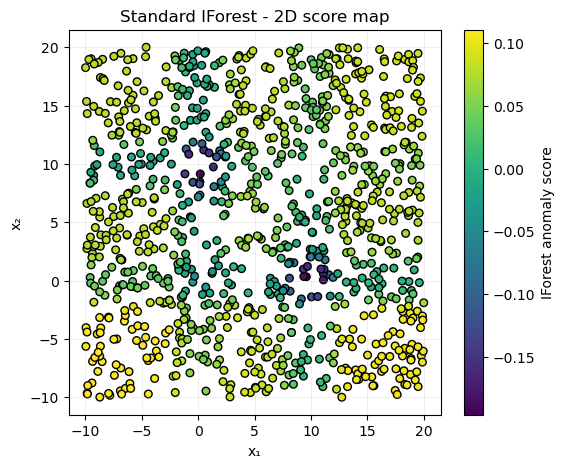

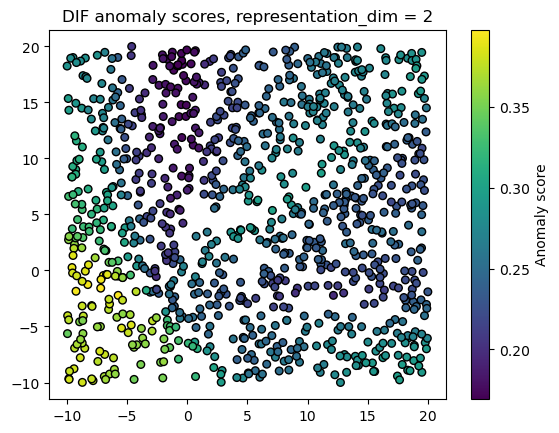

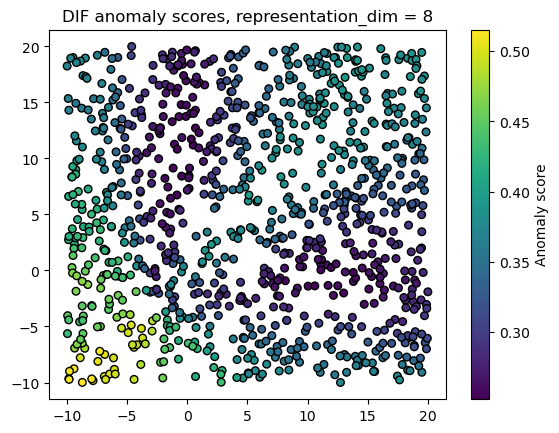

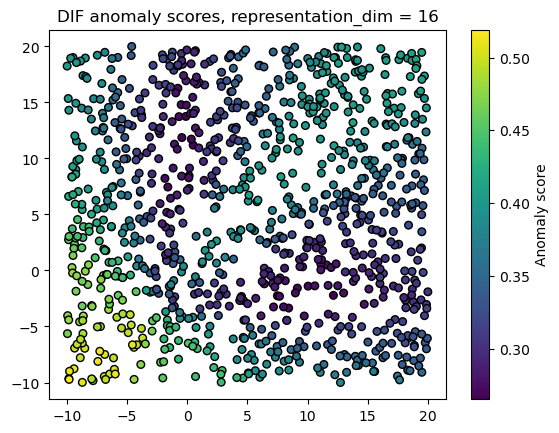

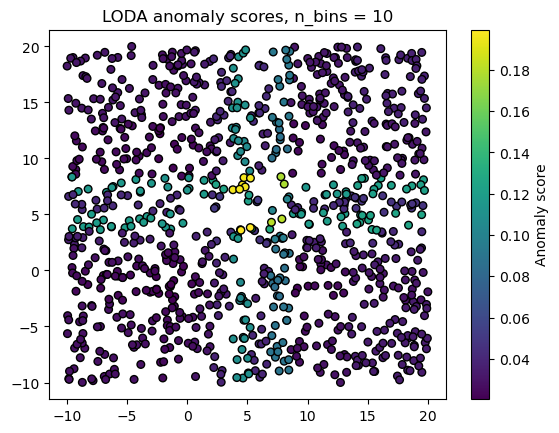

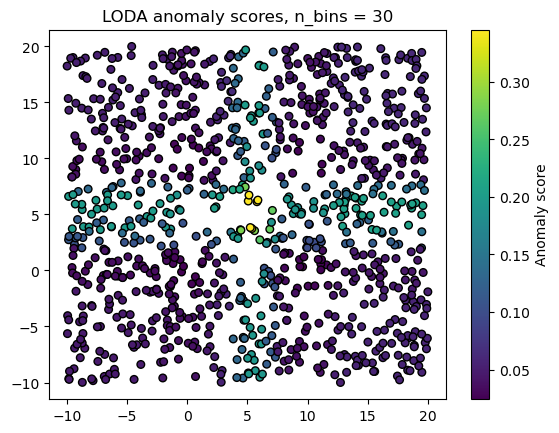

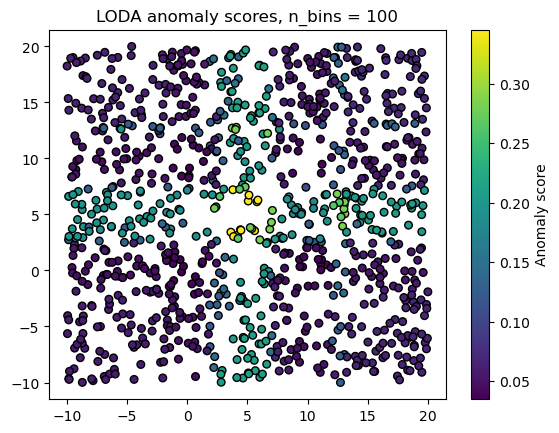

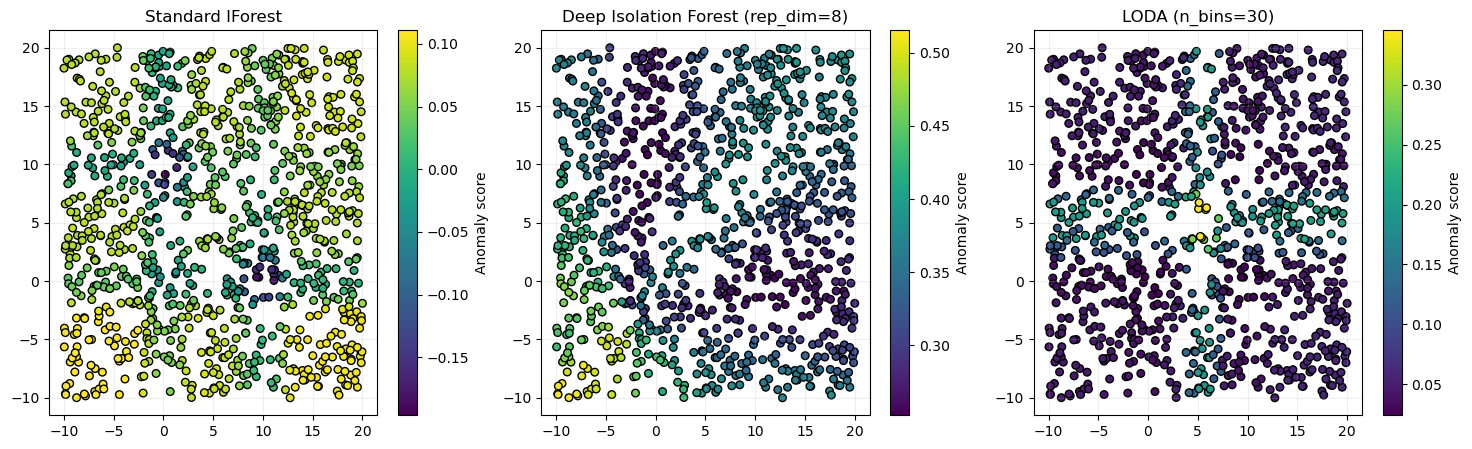

In [3]:
# Ex. 2
# 1. In this exercise we will try to see how the standard Isolation Forest algorithm introduces some artifacts when
# computing the anomaly scores. You will generate 2 clusters of 2-dimensional data using make blobs() function. The
# 2 clusters will have (10, 0) and (0, 10) as centers, 1 as standard deviation and 500 samples each.
# 2. You will fit an IForest model (from pyod.models.iforest) using this data (and a contamination rate of 0.02). 
# Test data will be generated from a uniform distribution over the interval (-10, 20) using np.random.uniform and will
# contain 1000 samples.
# 3. Find the anomaly scores for the test data and plot the samples using a colormap (related to the anomaly scores). 
# Observe the artefacts introduced by the axis-parallel separating hyperplanes used by standard IForest.
# 4. Repeat the same procedure for Deep Isolation Forest model (DIF from pyod.models.dif) and LODA(from pyod.models.loda)
# and use 3 sub plots for the 3 figures.
# 5. Try different number of neurons for the hidden layers used by DIF and different number of bins for LODA. Try to 
# explain why the score maps for LODA look that way.
# 6. Redo all the steps in 3D (use (0, 10, 0) and (10, 0 , 10) as centers for the two clusters).

# 1. using the make_blobs() function to generate 2 clusters of 2-dimensional data
# (10, 0) and (0, 10) as centers, 1 as standard deviation and 500 samples each
train_data_1, _ = make_blobs(n_samples=500, n_features=2, centers=[[10, 0]], cluster_std=1.0, random_state=1)
train_data_2, _ = make_blobs(n_samples=500, n_features=2, centers=[[0, 10]], cluster_std=1.0, random_state=2)
train_data = np.vstack([train_data_1, train_data_2])

# 2. fitting an IForest model using the training data and a contamination rate of 0.02
iforest = IForest(n_estimators=100, max_samples=256, contamination=0.02, random_state=42)
iforest.fit(train_data)

# generating test data from a uniform distribution over the interval (-10, 20) using np.random.uniform with 1000 samples
test_data = rng.uniform(low=-10, high=20, size=(1000, 2))

# 3. testing and plotting anomaly scores
scores_if = iforest.decision_function(test_data)  # higher = more anomalous
plt.figure(figsize=(6,5))
plt.scatter(test_data[:,0], test_data[:,1], c=scores_if, cmap='viridis', s=30, edgecolor='k')
plt.colorbar(label="IForest anomaly score")
plt.title("Standard IForest - 2D score map")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(alpha=0.2)
plt.show()

# 4. fitting DIF and LODA models
# DIF with different hidden neurons
dif_scores_dict = {}
for rep_dim in [2, 8, 16]:
    dif = DIF(
        n_ensemble=20,
        n_estimators=6,
        max_samples=256,
        contamination=0.02,
        representation_dim=rep_dim,
        batch_size=256,
        random_state=42,
        device='cpu'
    )
    dif.fit(train_data)
    scores = dif.decision_function(test_data)
    dif_scores_dict[rep_dim] = scores
    
    plt.figure()
    plt.scatter(test_data[:,0], test_data[:,1], c=scores, cmap='viridis', s=30, edgecolor='k')
    plt.title(f"DIF anomaly scores, representation_dim = {rep_dim}")
    plt.colorbar(label="Anomaly score")
    plt.show()

# LODA with different number of bins
loda_scores_dict = {}
for n_bins in [10, 30, 100]:
    loda = LODA(n_bins=n_bins, contamination=0.02)
    loda.fit(train_data)
    scores = loda.decision_function(test_data)
    loda_scores_dict[n_bins] = scores
    
    plt.figure()
    plt.scatter(test_data[:,0], test_data[:,1], c=scores, cmap='viridis', s=30, edgecolor='k')
    plt.title(f"LODA anomaly scores, n_bins = {n_bins}")
    plt.colorbar(label="Anomaly score")
    plt.show()

scores_dif = dif_scores_dict[8]
scores_loda = loda_scores_dict[30]

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# IForest
sc0 = axes[0].scatter(test_data[:,0], test_data[:,1], c=scores_if, cmap='viridis', s=30, edgecolor='k')
axes[0].set_title("Standard IForest")
axes[0].grid(alpha=0.2)
plt.colorbar(sc0, ax=axes[0], label="Anomaly score")

# DIF
sc1 = axes[1].scatter(test_data[:,0], test_data[:,1], c=scores_dif, cmap='viridis', s=30, edgecolor='k')
axes[1].set_title("Deep Isolation Forest (rep_dim=8)")
axes[1].grid(alpha=0.2)
plt.colorbar(sc1, ax=axes[1], label="Anomaly score")

# LODA
sc2 = axes[2].scatter(test_data[:,0], test_data[:,1], c=scores_loda, cmap='viridis', s=30, edgecolor='k')
axes[2].set_title("LODA (n_bins=30)")
axes[2].grid(alpha=0.2)
plt.colorbar(sc2, ax=axes[2], label="Anomaly score")

plt.show()

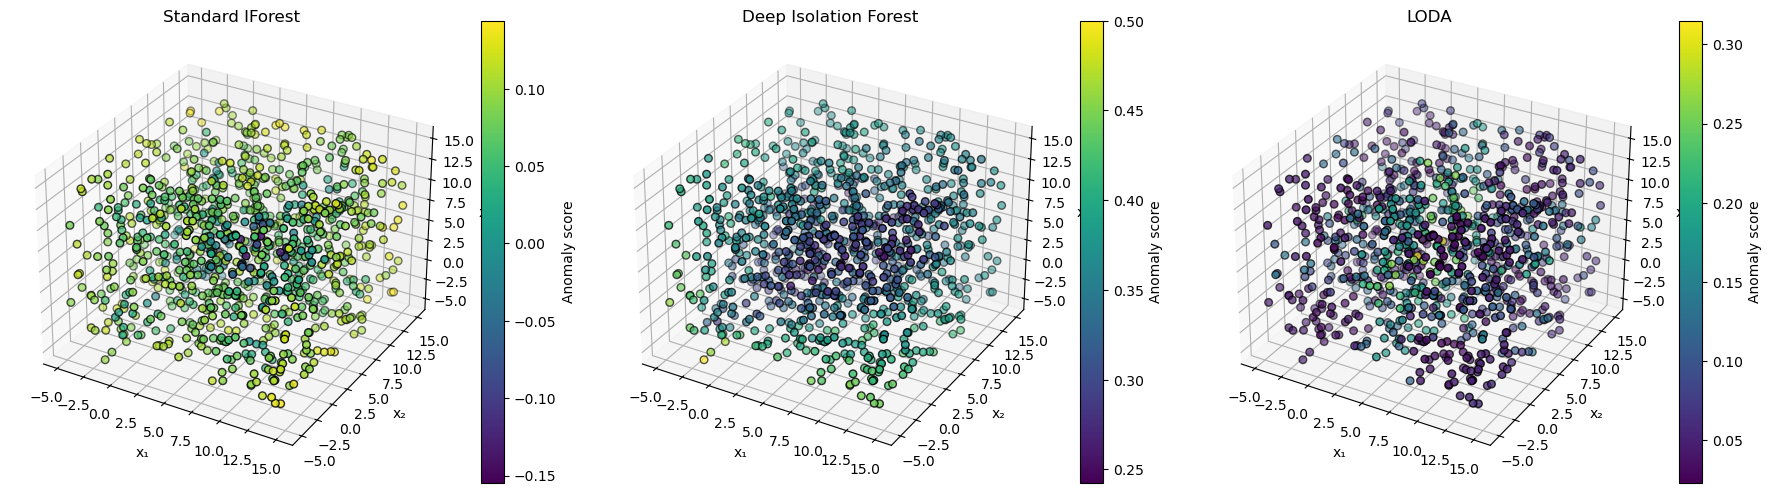

In [12]:
# 3D case (use (0, 10, 0) and (10, 0 , 10) as centers for the two clusters).
from mpl_toolkits.mplot3d import Axes3D

# generating 3D clusters with (0, 10, 0) and (10, 0 , 10) as centers
train_data_1, _ = make_blobs(n_samples=500, n_features=3, centers=[[0, 10, 0]], cluster_std=1.0, random_state=1)
train_data_2, _ = make_blobs(n_samples=500, n_features=3, centers=[[10, 0, 10]], cluster_std=1.0, random_state=2)
train_data = np.vstack([train_data_1, train_data_2])

# generating test data
test_data = rng.uniform(low=-5, high=15, size=(1000, 3))

# fitting IForest
iforest = IForest(n_estimators=100, max_samples=256, contamination=0.02, random_state=42)
iforest.fit(train_data)
scores_if = iforest.decision_function(test_data)

# DIF
dif = DIF(
    n_ensemble=20,
    n_estimators=6,
    max_samples=256,
    contamination=0.02,
    representation_dim=8,
    batch_size=256,
    random_state=42,
    device='cpu'
)
dif.fit(train_data)
scores_dif = dif.decision_function(test_data)

# LODA
loda = LODA(n_bins=30, contamination=0.02)
loda.fit(train_data)
scores_loda = loda.decision_function(test_data)

fig = plt.figure(figsize=(18,5))

# IForest
ax0 = fig.add_subplot(131, projection='3d')
p0 = ax0.scatter(test_data[:,0], test_data[:,1], test_data[:,2], c=scores_if, cmap='viridis', s=30, edgecolor='k')
ax0.set_title("Standard IForest")
ax0.set_xlabel("x₁"); ax0.set_ylabel("x₂"); ax0.set_zlabel("x₃")
fig.colorbar(p0, ax=ax0, label="Anomaly score")

# DIF
ax1 = fig.add_subplot(132, projection='3d')
p1 = ax1.scatter(test_data[:,0], test_data[:,1], test_data[:,2], c=scores_dif, cmap='viridis', s=30, edgecolor='k')
ax1.set_title("Deep Isolation Forest")
ax1.set_xlabel("x₁"); ax1.set_ylabel("x₂"); ax1.set_zlabel("x₃")
fig.colorbar(p1, ax=ax1, label="Anomaly score")

# LODA
ax2 = fig.add_subplot(133, projection='3d')
p2 = ax2.scatter(test_data[:,0], test_data[:,1], test_data[:,2], c=scores_loda, cmap='viridis', s=30, edgecolor='k')
ax2.set_title("LODA")
ax2.set_xlabel("x₁"); ax2.set_ylabel("x₂"); ax2.set_zlabel("x₃")
fig.colorbar(p2, ax=ax2, label="Anomaly score")

plt.tight_layout()
plt.show()


In [7]:
# Ex. 3
# 1. For this exercise we will need the shuttle dataset from ODDS (https://odds.cs.stonybrook.edu/shuttle-dataset/).
# Load the data using scipy.io.loadmat() and use train test split() to split it into train and test subsets (use 40%
# of data for testing). Normalize your data accordingly.
# 2. Fit IForest, LODA and DIF using the training data and compute the balanced accuracy (BA) and the area under the 
# curve (ROC AUC) using sklearn.metrics.roc auc score) for each model. Compute the mean BA and ROC AUC obtained for 
# 10 different train-test splits for each of the models.

# 1. loading the dataset
data = loadmat("shuttle.mat")
X = data['X']
y = data['y'].ravel()
y = (y != 1).astype(int)

n_runs = 10
ba_results = {'IForest': [], 'DIF': [], 'LODA': []}
roc_results = {'IForest': [], 'DIF': [], 'LODA': []}
scaler = StandardScaler()

for i in range(n_runs):
    # using train_test_split() to split it into train and test subsets
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=i, stratify=y)
    
    # normalizing the data
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    
    # 2. fitting IForest, LODA and DIF using the training data and computing BA and ROC AUC
    
    # IForest
    iforest = IForest(n_estimators=100, max_samples=256, contamination=0.02, random_state=i)
    iforest.fit(train_data_scaled)
    scores_if = iforest.decision_function(test_data_scaled)
    test_label_pred_if = iforest.predict(test_data_scaled)
    
    ba_results['IForest'].append(balanced_accuracy_score(test_labels, test_label_pred_if))
    roc_results['IForest'].append(roc_auc_score(test_labels, -scores_if))
    
    # DIF
    dif = DIF(n_ensemble=5, n_estimators=3, max_samples=256, contamination=0.02,
              representation_dim=4, batch_size=256, random_state=i, device='cpu')
    dif.fit(train_data_scaled)
    scores_dif = dif.decision_function(test_data_scaled)
    test_label_pred_dif = dif.predict(test_data_scaled)
    
    ba_results['DIF'].append(balanced_accuracy_score(test_labels, test_label_pred_dif))
    roc_results['DIF'].append(roc_auc_score(test_labels, -scores_dif))
    
    # LODA
    loda = LODA(n_bins=30, contamination=0.02)
    loda.fit(train_data_scaled)
    scores_loda = loda.decision_function(test_data_scaled)
    test_label_pred_loda = loda.predict(test_data_scaled)
    
    ba_results['LODA'].append(balanced_accuracy_score(test_labels, test_label_pred_loda))
    roc_results['LODA'].append(roc_auc_score(test_labels, -scores_loda))

# compute mean results
for model in ['IForest', 'DIF', 'LODA']:
    print(f"{model}: Mean BA = {np.mean(ba_results[model]):.4f}, Mean ROC AUC = {np.mean(roc_results[model]):.4f}")


IForest: Mean BA = 0.3565, Mean ROC AUC = 0.9975
DIF: Mean BA = 0.4987, Mean ROC AUC = 0.9495
LODA: Mean BA = 0.3899, Mean ROC AUC = 0.7818
